In [1]:
!pip install /kaggle/input/pip-install-lifelines/autograd-1.7.0-py3-none-any.whl
!pip install /kaggle/input/pip-install-lifelines/autograd-gamma-0.5.0.tar.gz
!pip install /kaggle/input/pip-install-lifelines/interface_meta-1.3.0-py3-none-any.whl
!pip install /kaggle/input/pip-install-lifelines/formulaic-1.0.2-py3-none-any.whl
!pip install /kaggle/input/pip-install-lifelines/lifelines-0.30.0-py3-none-any.whl

Processing /kaggle/input/pip-install-lifelines/autograd-1.7.0-py3-none-any.whl
Processing /kaggle/input/pip-install-lifelines/autograd-gamma-0.5.0.tar.gz
  Preparing metadata (setup.py) ... - done
  Created wheel for autograd-gamma: filename=autograd_gamma-0.5.0-py3-none-any.whl size=4030 sha256=62c8ba3848a6924259dcd2d7f8dfb2ab8fc29f6fd8b276a8d680df2011b7d1f7
  Stored in directory: /root/.cache/pip/wheels/6b/b5/e0/4c79e15c0b5f2c15ecf613c720bb20daab20a666eb67135155
Successfully built autograd-gamma
Processing /kaggle/input/pip-install-lifelines/interface_meta-1.3.0-py3-none-any.whl
Processing /kaggle/input/pip-install-lifelines/formulaic-1.0.2-py3-none-any.whl
Processing /kaggle/input/pip-install-lifelines/lifelines-0.30.0-py3-none-any.whl


In [2]:
import warnings
warnings.simplefilter(action='ignore')

import argparse
import os
import random,numpy
os.environ['CUBLAS_WORKSPACE_CONFIG'] = ':4096:8'

In [3]:
import pandas as pd
import pandas.api.types
import numpy as np

from lifelines.utils import concordance_index

In [4]:
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.optim as optim
import torch.nn.functional as F
import torch.utils.data
import torchvision
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import torchvision.transforms.functional as RF
from torchvision.models.feature_extraction import create_feature_extractor
from PIL import Image
import numpy as np
import random,cv2,pandas,os,numpy
import matplotlib.pyplot as plt
import matplotlib.animation as animation

In [5]:
from lightgbm import LGBMRegressor

from lifelines import KaplanMeierFitter, CoxPHFitter, LogNormalFitter, LogLogisticFitter, ExponentialFitter, WeibullFitter

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import log_loss
from sklearn.metrics import accuracy_score
from sklearn.metrics import r2_score

from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler

In [6]:
seed = 999
print("Random Seed: ", seed)
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)  # if you are using multi-GPU.
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
torch.use_deterministic_algorithms(True)

nz = 100
beta1 = 0.5
lr = 0.0001
batch_size=100
ngpu=1
ngf,nc = 3,3
ndf = 64

device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

Random Seed:  999


In [7]:
class ParticipantVisibleError(Exception):
    pass

def score(solution: pd.DataFrame, submission: pd.DataFrame, row_id_column_name: str) -> float:

    del solution[row_id_column_name]
    del submission[row_id_column_name]
    
    event_label = 'efs'
    interval_label = 'efs_time'
    prediction_label = 'prediction'
    for col in submission.columns:
        if not pandas.api.types.is_numeric_dtype(submission[col]):
            raise ParticipantVisibleError(f'Submission column {col} must be a number')
    # Merging solution and submission dfs on ID
    merged_df = pd.concat([solution, submission], axis=1)
    merged_df.reset_index(inplace=True)
    merged_df_race_dict = dict(merged_df.groupby(['race_group']).groups)
    metric_list = []
    for race in merged_df_race_dict.keys():
        # Retrieving values from y_test based on index
        indices = sorted(merged_df_race_dict[race])
        merged_df_race = merged_df.iloc[indices]
        # Calculate the concordance index
        c_index_race = concordance_index(
                        merged_df_race[interval_label],
                        -merged_df_race[prediction_label],
                        merged_df_race[event_label])
        metric_list.append(c_index_race)
    return float(np.mean(metric_list)-np.sqrt(np.var(metric_list)))

In [8]:
def calculate_survival_probabilities(df, time_col, event_col):
    kmf = KaplanMeierFitter()
    kmf.fit(df[time_col], df[event_col])
    return kmf.survival_function_at_times(df[time_col]).values

def preprocess_survival_data(df, time_col='efs_time', event_col='efs'):
    df['target'] = calculate_survival_probabilities(df, time_col, event_col)
    df.loc[df[event_col] == 0, 'target'] -= 0.2
    return df

In [9]:
train = pandas.read_csv('/kaggle/input/equity-post-HCT-survival-predictions/train.csv')
test = pandas.read_csv('/kaggle/input/equity-post-HCT-survival-predictions/test.csv')

In [10]:
encoder = LabelEncoder()
normalize = SimpleImputer(strategy='mean')

for i in zip(train.columns,train.dtypes):
    if i[1]=='O':
        train[i[0]] = train[i[0]].fillna('Unknown')
        train[i[0]]=encoder.fit_transform(train[i[0]].to_numpy().reshape(-1,1))
    else:
        if i[0]!='ID' and i[0]!='efs' and i[0]!='efs_time' and i[0]!='target':
            train[i[0]] = train[i[0]].fillna(0)
            #train[i[0]]=normalize.fit_transform(numpy.array(train[i[0]]).reshape(-1,1))

for i in zip(test.columns,test.dtypes):
    if i[1]=='O':
        test[i[0]] = test[i[0]].fillna('Unknown')
        test[i[0]]=encoder.fit_transform(test[i[0]].to_numpy().reshape(-1,1))
    else:
        if i[0]!='ID' and i[0]!='efs' and i[0]!='efs_time' and i[0]!='target':
            test[i[0]] = test[i[0]].fillna(0)
            #test[i[0]]=normalize.fit_transform(numpy.array(test[i[0]]).reshape(-1,1))

In [11]:
train = preprocess_survival_data(train)

In [12]:
X_train, X_test, y_train, y_test = train_test_split(train.drop(columns=['target']), train['target'], test_size=0.005, random_state=100)

In [13]:
id = X_test['ID']
y_true = X_test[['ID','efs', 'efs_time', 'race_group']].fillna(0)

X_train = X_train.drop(columns=['ID', 'efs', 'efs_time'])
X_test = X_test.drop(columns=['ID', 'efs', 'efs_time'])

X_train.head()

,dri_score,psych_disturb,cyto_score,diabetes,hla_match_c_high,hla_high_res_8,tbi_status,arrhythmia,hla_low_res_6,graft_type,...,karnofsky_score,hepatic_mild,tce_div_match,donor_related,melphalan_dose,hla_low_res_8,cardiac,hla_match_drb1_high,pulm_moderate,hla_low_res_10
6785,7,0,2,0,2.0,8.0,5,0,6.0,0,...,70.0,0,3,3,1,8.0,0,2.0,0,10.0
436,7,0,5,0,1.0,4.0,1,0,3.0,0,...,70.0,0,4,1,1,4.0,0,1.0,3,5.0
6445,1,0,0,0,2.0,8.0,0,0,6.0,1,...,80.0,0,2,3,1,8.0,0,2.0,0,10.0
4979,2,0,5,0,2.0,8.0,0,0,6.0,1,...,70.0,0,3,3,1,8.0,0,2.0,0,10.0
3192,3,0,7,0,2.0,8.0,0,0,6.0,0,...,90.0,0,3,1,1,8.0,0,2.0,0,10.0


In [14]:
y_true

,ID,efs,efs_time,race_group
23483,23483,0.0,61.121,3
9420,9420,1.0,7.563,0
16233,16233,1.0,4.774,1
19931,19931,0.0,21.675,1
14449,14449,0.0,43.689,2
...,...,...,...,...
20309,20309,1.0,4.445,4
25536,25536,1.0,4.573,3
12725,12725,1.0,7.394,0
15686,15686,0.0,25.749,5


In [15]:
def weights_init(m):
    if isinstance(m, nn.Linear):
        nn.init.xavier_normal_(m.weight.data, gain=0.02)
        if m.bias is not None:
            nn.init.constant_(m.bias.data, 0)

    elif isinstance(m, nn.GRUCell):
        nn.init.xavier_normal_(m.weight_ih.data) 
        nn.init.orthogonal_(m.weight_hh.data) 
        if m.bias is not None:
            nn.init.constant_(m.bias_ih.data, 0)  
            nn.init.constant_(m.bias_hh.data, 0) 

In [16]:
class high_regressor(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.rafire = torch.nn.Sequential(
            torch.nn.Linear(57, 128),
            nn.BatchNorm1d(128),
            torch.nn.Dropout(0.1),
            
            torch.nn.Linear(128, 256),
            nn.BatchNorm1d(256), 
            torch.nn.Dropout(0.1),
            
            torch.nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            torch.nn.Dropout(0.1),
            
            torch.nn.Linear(128, 64),
            nn.BatchNorm1d(64),
            nn.GELU(),
            torch.nn.Dropout(0.1),
            
            torch.nn.Linear(64, 1)
        )
        
    def forward(self,x):
        return self.rafire(x)

In [17]:
EFF_NET = high_regressor().float()
EFF_NET= nn.DataParallel(EFF_NET).to(device)
EFF_NET.apply(weights_init)

DataParallel(
  (module): high_regressor(
    (rafire): Sequential(
      (0): Linear(in_features=57, out_features=128, bias=True)
      (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): Dropout(p=0.1, inplace=False)
      (3): Linear(in_features=128, out_features=256, bias=True)
      (4): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): Dropout(p=0.1, inplace=False)
      (6): Linear(in_features=256, out_features=128, bias=True)
      (7): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (8): Dropout(p=0.1, inplace=False)
      (9): Linear(in_features=128, out_features=64, bias=True)
      (10): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (11): GELU(approximate='none')
      (12): Dropout(p=0.1, inplace=False)
      (13): Linear(in_features=64, out_features=1, bias=True)
    )
  )
)

In [18]:
criterion = nn.CrossEntropyLoss()
    

optimizer = optim.AdamW(EFF_NET.parameters(), lr=lr,betas=(beta1, 0.999))
scheduler=torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.86)

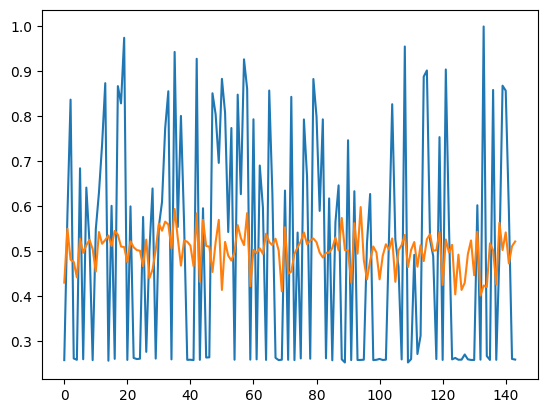

EPOCH : 1 LOSS : 0.5904752891313461


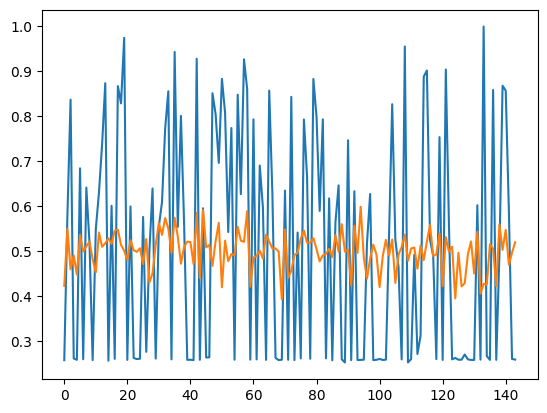

EPOCH : 2 LOSS : 0.5656700514561467


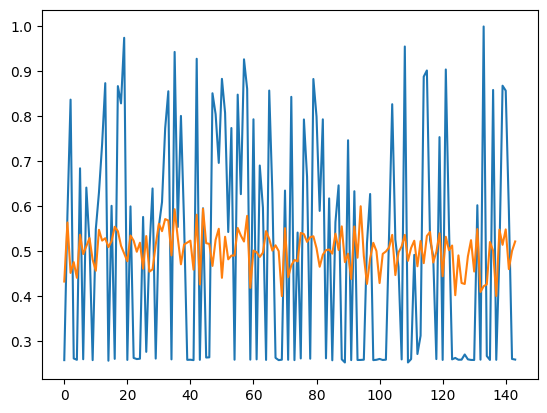

EPOCH : 3 LOSS : 0.5800379525016628


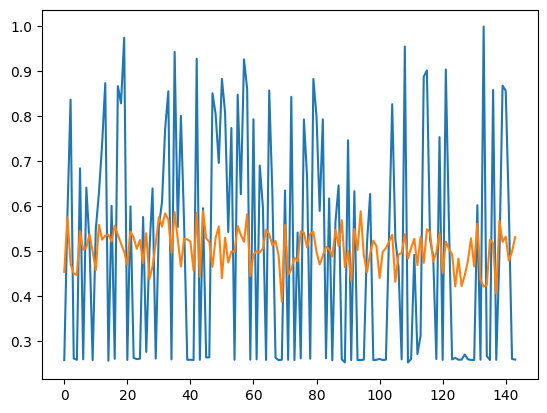

EPOCH : 4 LOSS : 0.5603017637304705


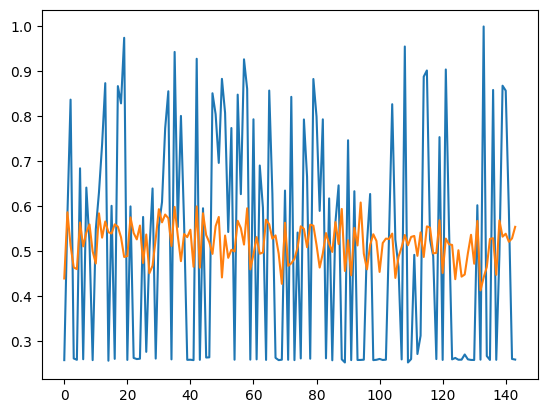

EPOCH : 5 LOSS : 0.5466473374501946


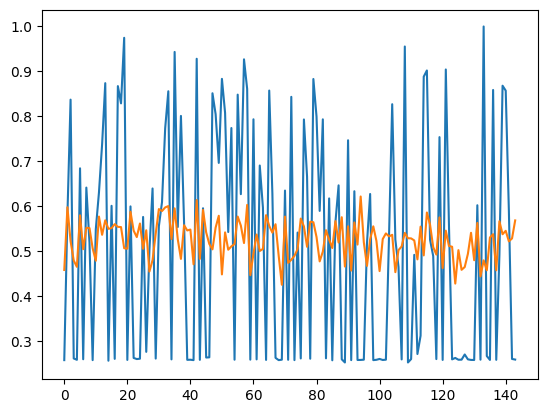

EPOCH : 6 LOSS : 0.5827602253486591


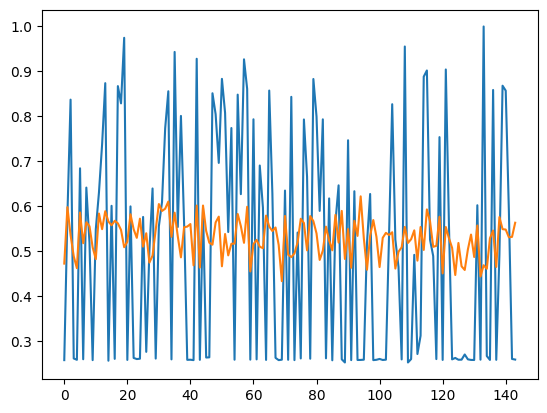

EPOCH : 7 LOSS : 0.5761287977909849


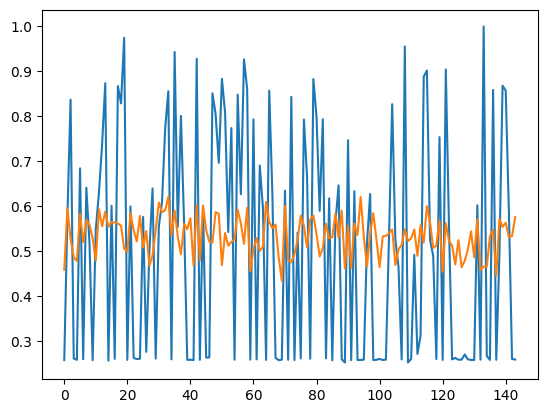

EPOCH : 8 LOSS : 0.5812451578499069


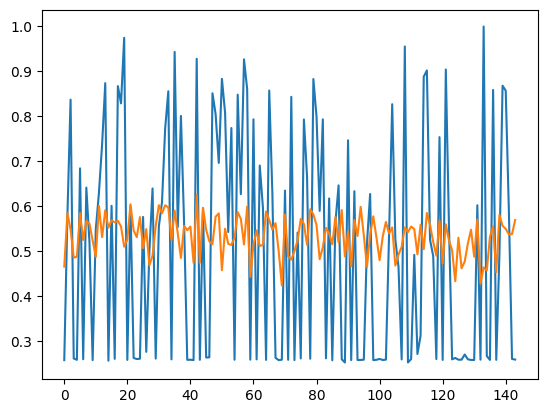

EPOCH : 9 LOSS : 0.5637250444301093


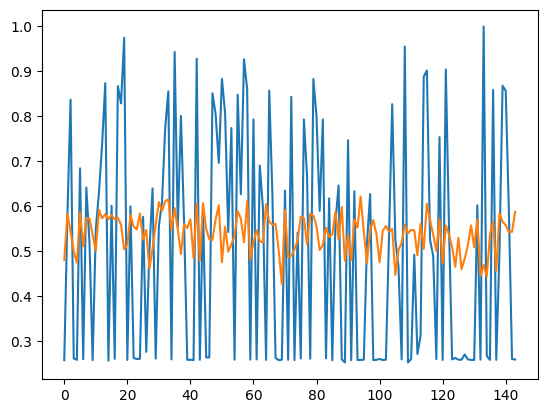

EPOCH : 10 LOSS : 0.5697006145710937


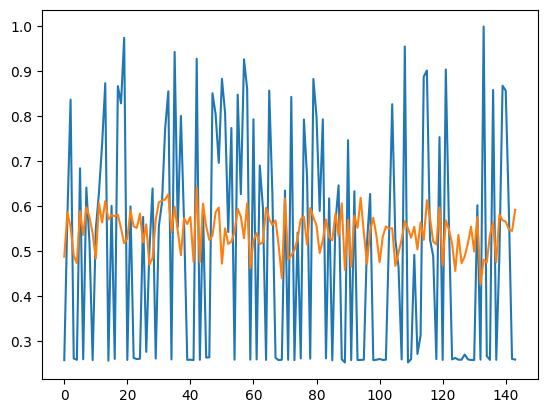

EPOCH : 11 LOSS : 0.5816302337322786


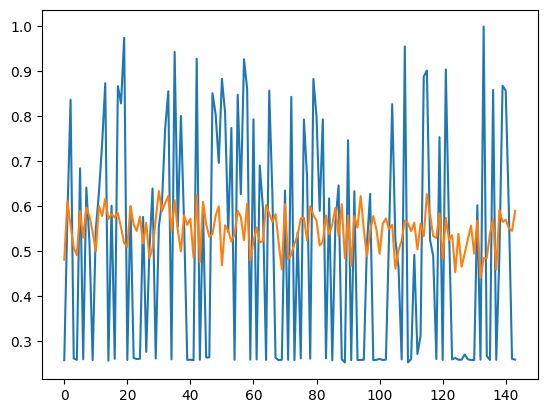

EPOCH : 12 LOSS : 0.5826639502548696


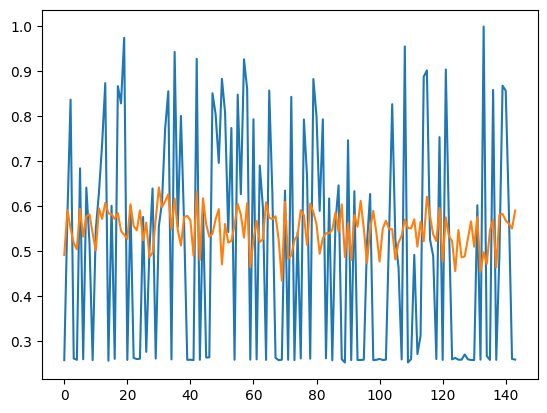

EPOCH : 13 LOSS : 0.5783116068338989


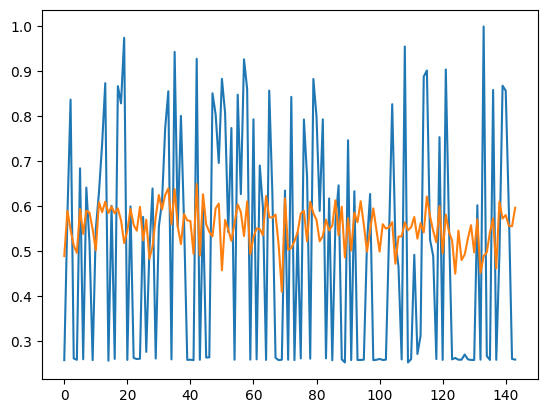

EPOCH : 14 LOSS : 0.5774814135854361


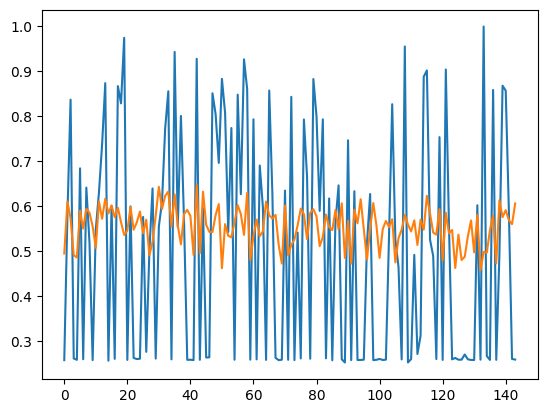

EPOCH : 15 LOSS : 0.58169511000058


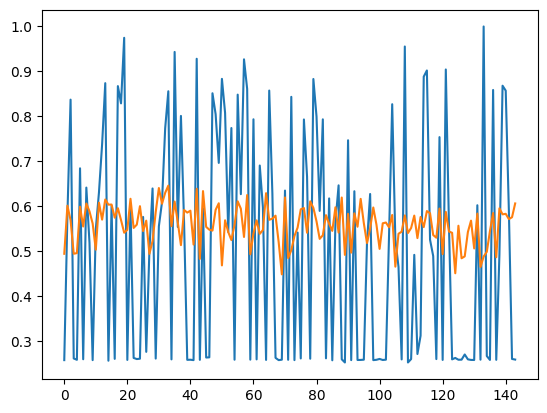

EPOCH : 16 LOSS : 0.5685127680104853


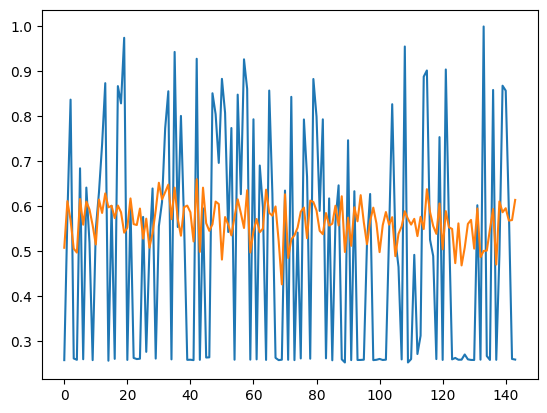

EPOCH : 17 LOSS : 0.5918784161394437


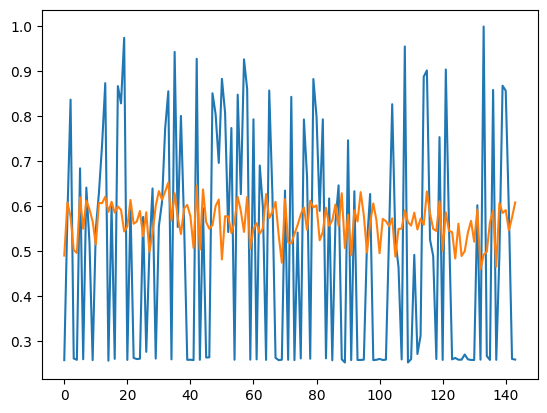

EPOCH : 18 LOSS : 0.5872885153400127


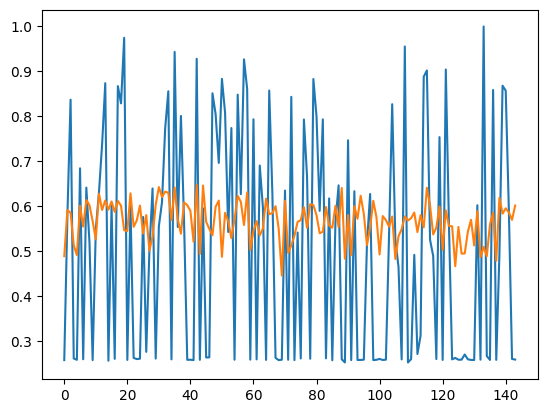

EPOCH : 19 LOSS : 0.585607914428049


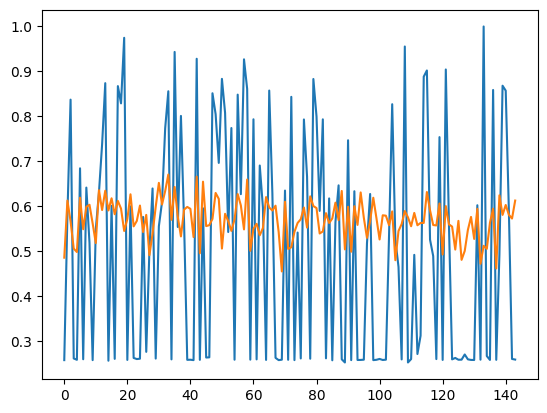

EPOCH : 20 LOSS : 0.5936144687420556


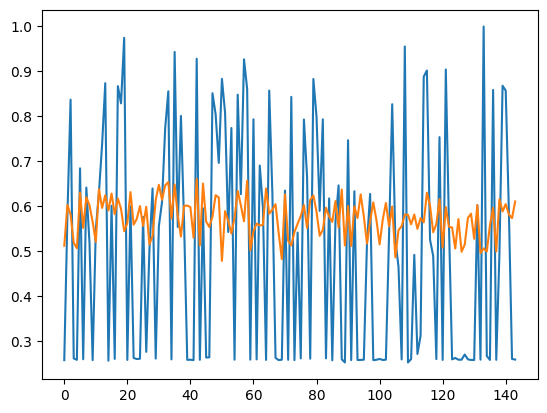

EPOCH : 21 LOSS : 0.5788313806203469


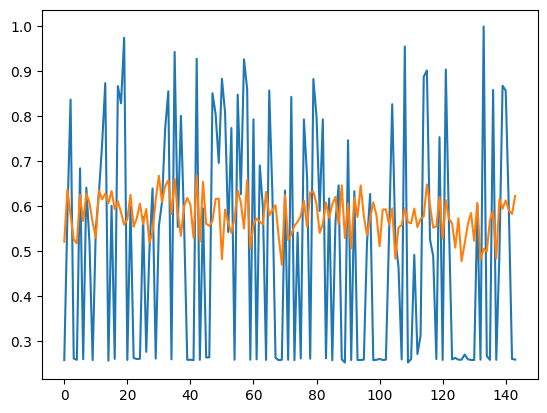

EPOCH : 22 LOSS : 0.5874040477133431


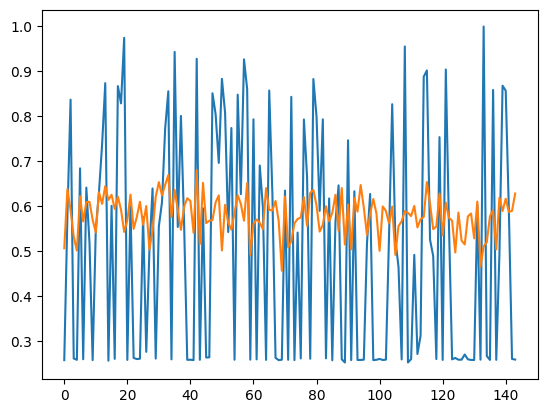

EPOCH : 23 LOSS : 0.5877596503197262


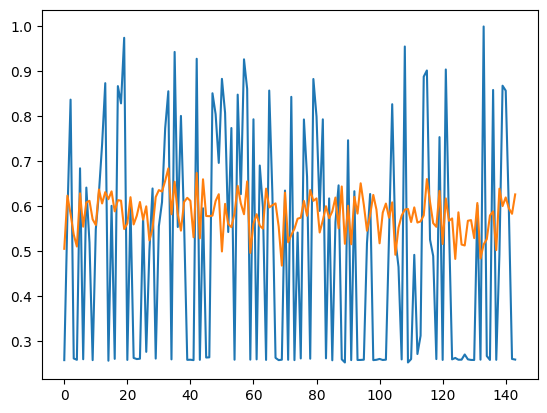

EPOCH : 24 LOSS : 0.5983529449289526


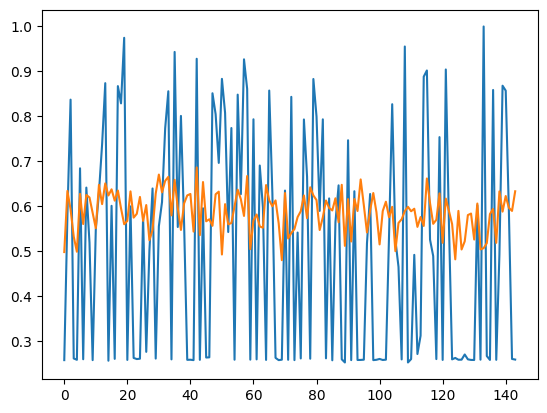

EPOCH : 25 LOSS : 0.5735034979264361


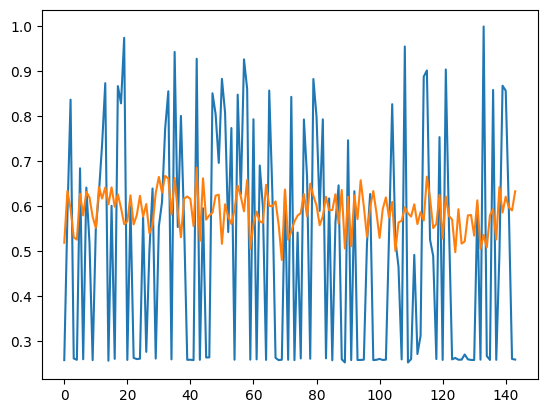

EPOCH : 26 LOSS : 0.6034498663895319


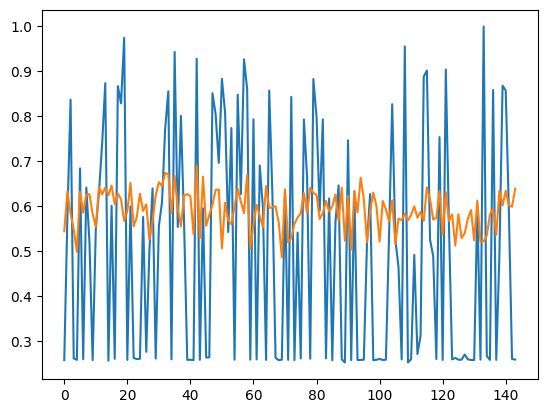

EPOCH : 27 LOSS : 0.5946532212898719


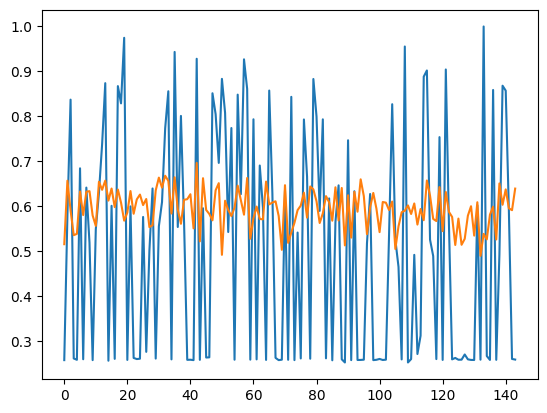

EPOCH : 28 LOSS : 0.5827097044759031


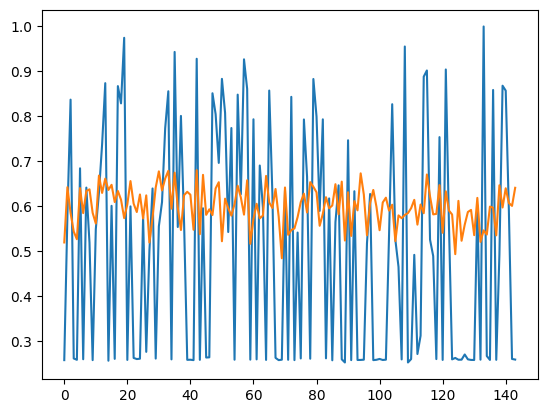

EPOCH : 29 LOSS : 0.5686782585063028


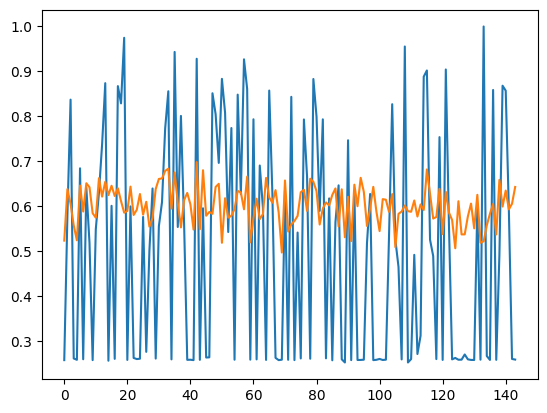

EPOCH : 30 LOSS : 0.570618327924573


In [19]:
from torch.autograd import Variable 

Fold, epoch = 5, 0
kf = KFold(n_splits=Fold)

while True:
    loss, r2_loss = 0, 0
    epoch+=1
    for i, (train_index, test_index) in enumerate(kf.split(X_train)):
            
        x_fold=X_train.to_numpy()
        y_fold=y_train.to_numpy()
        
        x_fold = torch.utils.data.DataLoader(torch.FloatTensor(x_fold).to(device), batch_size=batch_size)
        y_fold = torch.utils.data.DataLoader(torch.FloatTensor(y_fold).to(device), batch_size=batch_size)
        
        for data,label in zip(x_fold,y_fold):
            optimizer.zero_grad()
            output = EFF_NET(data).view(-1)
            err_ = criterion(output, label)
            err_.backward()
            optimizer.step()

    x_test_fold = torch.FloatTensor(X_test.to_numpy()).to(device)
    
    output_ = EFF_NET(x_test_fold).view(-1).sigmoid().cpu().detach().numpy()
    submission = pandas.DataFrame({'ID': id, 'prediction': output_}).fillna(0)
    score_ = score(submission.copy(), y_true.copy(), 'ID') 
    plt.plot(y_test.to_numpy())
    plt.plot(output_)
    plt.show()
        
    torch.save(EFF_NET.state_dict(),f'/kaggle/working/{score_}.pth')
    print(f"EPOCH : {epoch} LOSS : {score_}")
    #print(output, y_test_fold)
    if epoch==30:
        break